In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

In [2]:
import os
notebook_path = os.path.abspath("double_descent_mtcars_reg.ipynb")
print(notebook_path)
csv_path = os.path.join(os.path.dirname(notebook_path), "data/mt_cars.csv")
print(csv_path)

/Users/jeanortega/PycharmProjects/pythonProject1/double_descent_mtcars_reg.ipynb
/Users/jeanortega/PycharmProjects/pythonProject1/data/mt_cars.csv


In [3]:
df = pd.read_csv(csv_path)

In [4]:
df

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


# Split X and y

In [5]:
TARGET_COL = "mpg"

In [6]:
NON_NUMERIC_COLS = ["model"]

In [7]:
y = df[TARGET_COL]
X = df.drop([TARGET_COL] + NON_NUMERIC_COLS,axis=1)

# Functions

In [8]:
random_state = 10 # For reproducibility
num_sampled_rows = 4
num_sampled_columns = 5

In [9]:
indices = np.random.choice(df.index, num_sampled_rows, replace=False)

In [10]:
# X_subset = X.sample(n=num_sampled_rows, random_state=random_state, axis=0)
X_subset = X.iloc[indices]
y_subset = y.iloc[indices]

In [11]:
X_subset = X_subset.sample(n=num_sampled_columns, random_state=random_state, axis=1)

In [12]:
X_subset

,gear,hp,qsec,vs,drat
1,4,110,17.02,0,3.90
7,4,62,20.00,1,3.69
15,3,215,17.82,0,3.00
4,3,175,17.02,0,3.15


In [13]:
y_subset

1     21.0
7     24.4
15    10.4
4     18.7
Name: mpg, dtype: float64

# Using the package

In [14]:
from double_descent_dar import sample_eval

In [15]:
random_state = 10 # For reproducibility
num_sampled_rows = 10
num_sampled_columns = 5

In [16]:
X_sub, y_sub = sample_eval.sample_rows_and_cols(X, y, num_sampled_rows=num_sampled_rows, num_sampled_columns=num_sampled_columns, random_state=random_state, replace=False) 

In [17]:
X_sub

,gear,hp,qsec,vs,drat
19,4,65,19.90,1,4.22
16,3,230,17.42,0,3.23
12,3,180,17.60,0,3.07
17,4,66,19.47,1,4.08
5,3,105,20.22,1,2.76
14,3,205,17.98,0,2.93
8,4,95,22.90,1,3.92
18,4,52,18.52,1,4.93
20,3,97,20.01,1,3.70
28,5,264,14.50,0,4.22


In [18]:
y_sub

19    33.9
16    14.7
12    17.3
17    32.4
5     18.1
14    10.4
8     22.8
18    30.4
20    21.5
28    15.8
Name: mpg, dtype: float64

In [19]:
# model = RandomForestRegressor()
# model = linear_model.Ridge(alpha=.5)
model = linear_model.LinearRegression(fit_intercept=True)

In [20]:
# my_metric = root_mean_squared_error
my_metric = mean_absolute_error

In [21]:
# Set for exact reproducibility.
random_state = 10

In [22]:
train_proportion = 0.5
sample_eval.sample_and_calc_metric(X, y, num_sampled_rows, num_sampled_columns, train_proportion, model, my_metric, replace=False, random_state=random_state)

{'train': np.float64(2.9132252166164105e-14),
 'test': np.float64(13.76922611398436)}

In [23]:
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric(X, y, num_sampled_rows, num_sampled_columns_local, train_proportion, model, my_metric, replace=False, random_state=random_state)['test']

In [24]:
num_samples = 1000
metric_all_samples = []
for num_sampled_columns in range(1, X.shape[1]-1):
    metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))

In [25]:
for key, values in metric_all_samples:
    the_mean = np.mean(values)
    the_stdev = np.std(values)
    print(f'num_cols: {key}, mean error: {the_mean:9.3f}, stdev of error: {the_stdev:4.1f}')

num_cols: 1, mean error:     5.504, stdev of error:  2.5
num_cols: 2, mean error:     4.780, stdev of error:  9.7
num_cols: 3, mean error:     7.291, stdev of error: 12.5
num_cols: 4, mean error:    19.824, stdev of error: 66.8
num_cols: 5, mean error:    13.918, stdev of error: 64.2
num_cols: 6, mean error:     9.474, stdev of error: 23.4
num_cols: 7, mean error:     8.698, stdev of error: 21.1
num_cols: 8, mean error:     7.539, stdev of error: 12.8


In [26]:
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]

In [27]:
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]

In [28]:
my_metric.__name__

'mean_absolute_error'

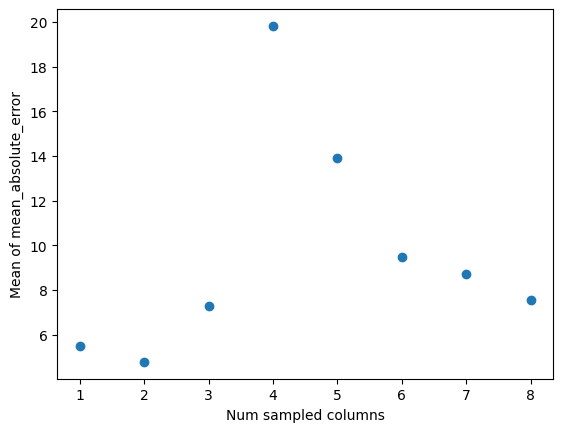

In [29]:
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()